<a href="https://colab.research.google.com/github/goto-a-toast/LSTM-stock-pred/blob/main/lstm-stock-prediction-83Fof/stock_prediction/LSTM_Stock_Prediction_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 LSTM株価予測モデル - 複数銘柄対応

このノートブックは、LSTMニューラルネットワークを使って日本株の株価を予測します。

## 📋 実行手順

1. **ライブラリのインストール** → 実行時間: 約1分
2. **銘柄検索と選択** → お好きな企業の銘柄を検索できます
3. **データ取得** → 実行時間: 約30秒
4. **モデル訓練** → 実行時間: 約5～10分
5. **予測と可視化** → 実行時間: 約30秒
6. **将来予測** → x日先の株価を予測

## ⚠️ 注意事項

このプログラムは**教育・学習目的**です。実際の投資判断には使用しないでください。

---

## 1️⃣ ライブラリのインストール

必要なPythonライブラリをインストールします。
（Google Colabには既にインストールされているものもあります）

In [1]:
# 必要なライブラリをインストール
!pip install yfinance -q

print("✓ ライブラリのインストールが完了しました！")

✓ ライブラリのインストールが完了しました！


## 2️⃣ ライブラリのインポート

必要なライブラリをすべてインポートします。

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# グラフの設定
plt.rcParams['figure.figsize'] = (15, 6)
%matplotlib inline

print("✓ ライブラリのインポートが完了しました！")

✓ ライブラリのインポートが完了しました！


## 2️⃣-1 銘柄検索機能

企業名から銘柄コードを検索できます。主要な日本企業のリストから検索が可能です。

In [3]:
# 主要な日本企業の銘柄コード辞書
STOCK_DICT = {
    # 自動車
    'トヨタ自動車': '7203.T', 'トヨタ': '7203.T', 'TOYOTA': '7203.T',
    'ホンダ': '7267.T', '本田技研工業': '7267.T', 'HONDA': '7267.T',
    '日産自動車': '7201.T', '日産': '7201.T', 'NISSAN': '7201.T',
    'マツダ': '7261.T', 'MAZDA': '7261.T',
    'スズキ': '7269.T', 'SUZUKI': '7269.T',

    # 電機
    'ソニーグループ': '6758.T', 'ソニー': '6758.T', 'SONY': '6758.T',
    'パナソニック': '6752.T', 'Panasonic': '6752.T',
    '日立製作所': '6501.T', '日立': '6501.T', 'HITACHI': '6501.T',
    '東芝': '6502.T', 'TOSHIBA': '6502.T',
    '三菱電機': '6503.T',
    '富士通': '6702.T', 'FUJITSU': '6702.T',
    'NEC': '6701.T', '日本電気': '6701.T',

    # 通信
    'NTT': '9432.T', '日本電信電話': '9432.T',
    'KDDI': '9433.T',
    'ソフトバンクグループ': '9984.T', 'ソフトバンク': '9434.T',
    '楽天グループ': '4755.T', '楽天': '4755.T',

    # 金融
    '三菱UFJフィナンシャル・グループ': '8306.T', '三菱UFJ': '8306.T',
    '三井住友フィナンシャルグループ': '8316.T', '三井住友': '8316.T',
    'みずほフィナンシャルグループ': '8411.T', 'みずほ': '8411.T',
    '野村ホールディングス': '8604.T', '野村': '8604.T',

    # ゲーム・エンタメ
    '任天堂': '7974.T', 'Nintendo': '7974.T',
    'バンダイナムコホールディングス': '7832.T', 'バンナム': '7832.T',
    'カプコン': '9697.T', 'CAPCOM': '9697.T',
    'コナミグループ': '9766.T', 'コナミ': '9766.T',

    # 小売・EC
    'ファーストリテイリング': '9983.T', 'ユニクロ': '9983.T', 'UNIQLO': '9983.T',
    'セブン&アイ・ホールディングス': '3382.T', 'セブンイレブン': '3382.T',
    'イオン': '8267.T', 'AEON': '8267.T',

    # 製薬
    '武田薬品工業': '4502.T', '武田': '4502.T', 'TAKEDA': '4502.T',
    'アステラス製薬': '4503.T', 'アステラス': '4503.T',
    '第一三共': '4568.T',
    'エーザイ': '4523.T',

    # 重工業
    '三菱重工業': '7011.T', '三菱重工': '7011.T',
    '川崎重工業': '7012.T', '川崎重工': '7012.T',
    'IHI': '7013.T',

    # その他
    'キーエンス': '6861.T', 'KEYENCE': '6861.T',
    'ファナック': '6954.T', 'FANUC': '6954.T',
    '信越化学工業': '4063.T', '信越化学': '4063.T',
}

def search_stock(keyword):
    """企業名から銘柄コードを検索"""
    results = []
    keyword_lower = keyword.lower()

    for company, ticker in STOCK_DICT.items():
        if keyword_lower in company.lower():
            results.append((company, ticker))

    return results

def get_company_name(ticker):
    """銘柄コードから企業名を取得"""
    # 辞書から逆引き
    for company, code in STOCK_DICT.items():
        if code == ticker:
            return company

    # yfinanceから取得を試みる
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        if 'longName' in info:
            return info['longName']
        elif 'shortName' in info:
            return info['shortName']
    except:
        pass

    # どちらも失敗した場合はティッカーシンボルを返す
    return ticker

# 銘柄検索の例
print("【銘柄検索機能】\n")
print("使用例:")
print("  search_stock('トヨタ')  → トヨタ自動車の銘柄コードを検索")
print("  search_stock('ソニー')  → ソニーの銘柄コードを検索")
print("  get_company_name('7203.T')  → 銘柄コードから企業名を取得\n")

# 試しに検索してみる
print("検索例: 'ソニー'")
results = search_stock('ソニー')
for company, ticker in results:
    print(f"  {company}: {ticker}")

print(f"\n企業名取得例: '7203.T'")
print(f"  {get_company_name('7203.T')}")

print("\n✓ 銘柄検索機能の準備が完了しました！")

【銘柄検索機能】

使用例:
  search_stock('トヨタ')  → トヨタ自動車の銘柄コードを検索
  search_stock('ソニー')  → ソニーの銘柄コードを検索
  get_company_name('7203.T')  → 銘柄コードから企業名を取得

検索例: 'ソニー'
  ソニーグループ: 6758.T
  ソニー: 6758.T

企業名取得例: '7203.T'
  トヨタ自動車

✓ 銘柄検索機能の準備が完了しました！


In [4]:
# === 設定パラメータ ===

# 株式銘柄（自由に変更してください）
TICKER = "7269.T"  # 任意の銘柄
# TICKER = "7269.T"  # スズキ
# TICKER = "7203.T"  # トヨタ自動車
# 他の例:
# TICKER = "6758.T"  # ソニー
# TICKER = "7974.T"  # 任天堂
# TICKER = "9984.T"  # ソフトバンクグループ

# 企業名を取得
COMPANY_NAME = get_company_name(TICKER)

# データ取得期間
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5*365)  # 過去5年分

# モデルパラメータ
LOOK_BACK = 60  # 過去60日分のデータを使って予測
TRAIN_RATIO = 0.8  # データの80%を訓練用、20%をテスト用に
EPOCHS = 50  # トレーニング回数
BATCH_SIZE = 32  # バッチサイズ

# 将来予測パラメータ
FORECAST_DAYS = 30  # 何日先まで予測するか（1～90日程度を推奨）

print("✓ パラメータ設定完了")
print(f"  企業名: {COMPANY_NAME}")
print(f"  銘柄コード: {TICKER}")
print(f"  期間: {START_DATE.date()} ～ {END_DATE.date()}")
print(f"  過去参照日数: {LOOK_BACK}日")
print(f"  将来予測日数: {FORECAST_DAYS}日")

✓ パラメータ設定完了
  企業名: スズキ
  銘柄コード: 7269.T
  期間: 2021-02-13 ～ 2026-02-12
  過去参照日数: 60日
  将来予測日数: 30日


## 4️⃣ データ取得

Yahoo Financeから株価データを取得します。

In [5]:
print(f"\n{'='*60}")
print(f"株価データを取得中: {COMPANY_NAME} ({TICKER})")
print(f"期間: {START_DATE.date()} ～ {END_DATE.date()}")
print(f"{'='*60}\n")

# yfinanceを使ってデータをダウンロード
stock_data = yf.download(TICKER, start=START_DATE, end=END_DATE)

if stock_data.empty:
    print("エラー: データが取得できませんでした。")
else:
    print(f"✓ {len(stock_data)}日分のデータを取得しました！\n")

    # データの最初の5行を表示
    print("【最初の5行】")
    print(stock_data.head())
    print()

    # 統計情報を表示
    print("【終値の統計情報】")
    print(stock_data['Close'].describe())


株価データを取得中: スズキ (7269.T)
期間: 2021-02-13 ～ 2026-02-12



[*********************100%***********************]  1 of 1 completed

✓ 1221日分のデータを取得しました！

【最初の5行】
Price             Close         High          Low         Open   Volume
Ticker           7269.T       7269.T       7269.T       7269.T   7269.T
Date                                                                   
2021-02-15  1118.400635  1123.361283  1108.028371  1114.792891  5383600
2021-02-16  1152.673950  1161.242340  1124.713940  1124.939424  7076400
2021-02-17  1170.261963  1172.065835  1142.978399  1166.654219  5827600
2021-02-18  1132.606079  1183.339977  1131.027691  1175.448037  5956800
2021-02-19  1116.370972  1129.674524  1106.900646  1122.910006  4374400

【終値の統計情報】
Ticker       7269.T
count   1221.000000
mean    1411.800489
std      388.897420
min      813.187622
25%     1093.798706
50%     1287.703003
75%     1698.050293
max     2451.500000


In [6]:
print(f"\n{'='*60}")
print(f"株価データを取得中: {TICKER}")
print(f"期間: {START_DATE.date()} ～ {END_DATE.date()}")
print(f"{'='*60}\n")

# yfinanceを使ってデータをダウンロード
stock_data = yf.download(TICKER, start=START_DATE, end=END_DATE)

if stock_data.empty:
    print("エラー: データが取得できませんでした。")
else:
    print(f"✓ {len(stock_data)}日分のデータを取得しました！\n")

    # データの最初の5行を表示
    print("【最初の5行】")
    print(stock_data.head())
    print()

    # 統計情報を表示
    print("【終値の統計情報】")
    print(stock_data['Close'].describe())

[*********************100%***********************]  1 of 1 completed


株価データを取得中: 7269.T
期間: 2021-02-13 ～ 2026-02-12

✓ 1221日分のデータを取得しました！

【最初の5行】
Price             Close         High          Low         Open   Volume
Ticker           7269.T       7269.T       7269.T       7269.T   7269.T
Date                                                                   
2021-02-15  1118.400635  1123.361283  1108.028371  1114.792891  5383600
2021-02-16  1152.673950  1161.242340  1124.713940  1124.939424  7076400
2021-02-17  1170.261963  1172.065835  1142.978399  1166.654219  5827600
2021-02-18  1132.606079  1183.339977  1131.027691  1175.448037  5956800
2021-02-19  1116.370972  1129.674524  1106.900646  1122.910006  4374400

【終値の統計情報】
Ticker       7269.T
count   1221.000000
mean    1411.800489
std      388.897420
min      813.187622
25%     1093.798706
50%     1287.703003
75%     1698.050293
max     2451.500000


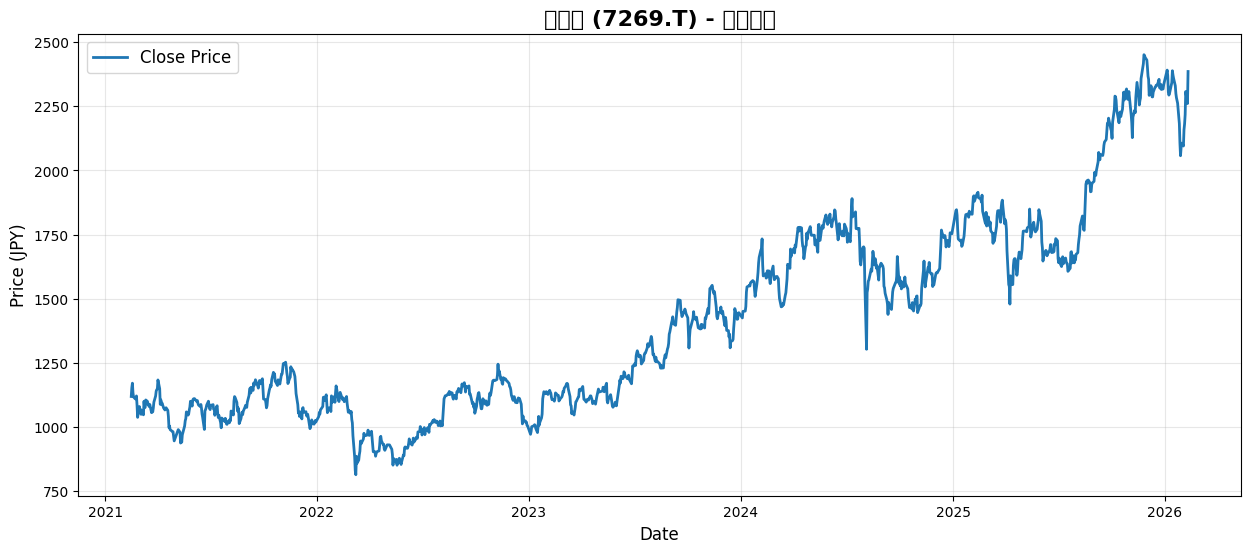

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', linewidth=2)
plt.title(f'{COMPANY_NAME} ({TICKER}) - 株価推移', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

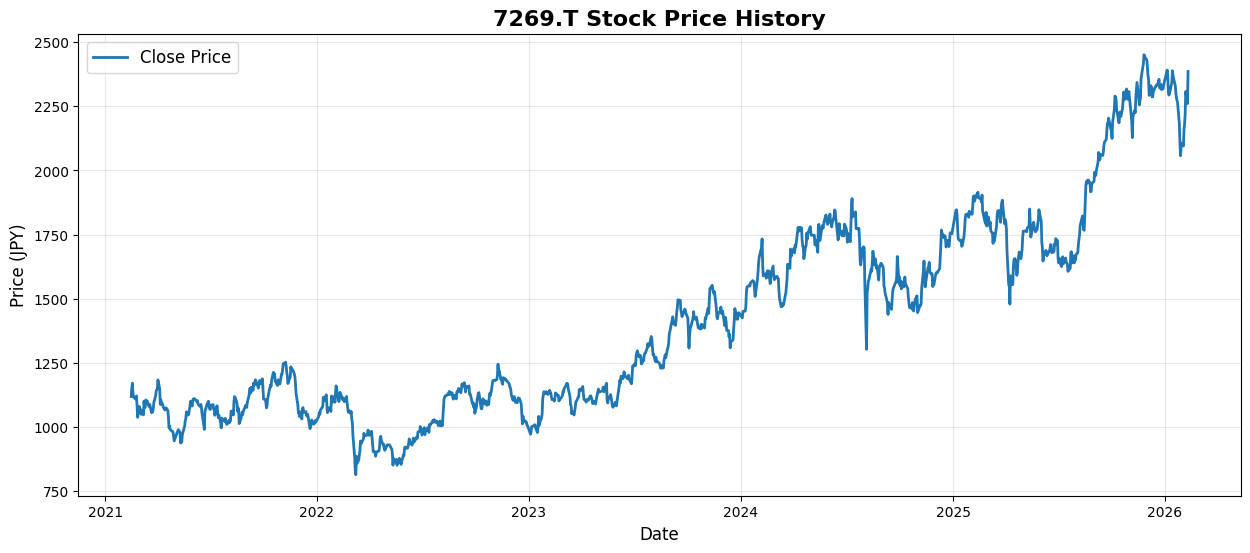

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', linewidth=2)
plt.title(f'{TICKER} Stock Price History', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 6️⃣ データ前処理

データを正規化して、LSTM用の形式に変換します。

In [9]:
print("【データの前処理】\n")

# 終値（Close）のデータだけを使用
close_prices = stock_data['Close'].values.reshape(-1, 1)
print(f"1. 終値データを抽出: {len(close_prices)}日分")

# データを訓練用とテスト用に分割（正規化前に分割）
train_size = int(len(close_prices) * TRAIN_RATIO)
train_prices = close_prices[:train_size]
test_prices = close_prices[train_size:]

# データの正規化（0～1の範囲に変換）
# 重要: スケーラーは訓練データのみでfitする（データリーケージ防止）
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_prices)  # 訓練データのみでfit
scaled_train = scaler.transform(train_prices)
scaled_test = scaler.transform(test_prices)

# 予測用に結合（LOOK_BACK期間のため）
scaled_data = np.vstack([scaled_train, scaled_test])
train_data = scaled_train
test_data = scaled_data[train_size - LOOK_BACK:]

print(f"2. データを正規化（0～1の範囲）- 訓練データのみでスケーラーをフィット")
print(f"3. データ分割:")
print(f"   - 訓練用: {len(train_data)}日分")
print(f"   - テスト用: {len(test_data) - LOOK_BACK}日分")

# LSTM用のデータ形式に変換
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_data, LOOK_BACK)
X_test, y_test = create_dataset(test_data, LOOK_BACK)

# LSTMの入力形式に変換: [サンプル数, タイムステップ, 特徴量]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"4. LSTM用データ形式に変換")
print(f"   - 訓練データ形状: {X_train.shape}")
print(f"   - テストデータ形状: {X_test.shape}")
print("\n✓ データ前処理完了！")

【データの前処理】

1. 終値データを抽出: 1221日分
2. データを正規化（0～1の範囲）- 訓練データのみでスケーラーをフィット
3. データ分割:
   - 訓練用: 976日分
   - テスト用: 245日分
4. LSTM用データ形式に変換
   - 訓練データ形状: (916, 60, 1)
   - テストデータ形状: (245, 60, 1)

✓ データ前処理完了！


## 7️⃣ LSTMモデルの構築

3層のLSTMニューラルネットワークを構築します。

In [10]:
print("【モデルの構築】\n")

model = Sequential([
    # 第1層: LSTM（50ユニット）
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # 過学習を防ぐ

    # 第2層: LSTM（50ユニット）
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    # 第3層: LSTM（50ユニット）
    LSTM(units=50),
    Dropout(0.2),

    # 出力層: 予測値（1つ）
    Dense(units=1)
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

print("モデル構造:")
model.summary()
print("\n✓ モデル構築完了！")

【モデルの構築】

モデル構造:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)


✓ モデル構築完了！


## 8️⃣ モデルのトレーニング

LSTMモデルをトレーニングします。（この処理には5～10分かかります）

In [11]:
print("【モデルのトレーニング】")
print(f"エポック数: {EPOCHS}")
print(f"バッチサイズ: {BATCH_SIZE}")
print("\nトレーニング開始...\n")

# Early Stopping（学習が改善しなくなったら自動停止）
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# トレーニング実行
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ トレーニング完了！")

【モデルのトレーニング】
エポック数: 50
バッチサイズ: 32

トレーニング開始...

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0534 - val_loss: 0.0459
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 0.0118
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0117
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0060 - val_loss: 0.0171
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0053 - val_loss: 0.0163
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0119
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - val_loss: 0.0089
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 12/50
29/

## 9️⃣ トレーニング履歴の可視化

学習の進捗をグラフで確認します。

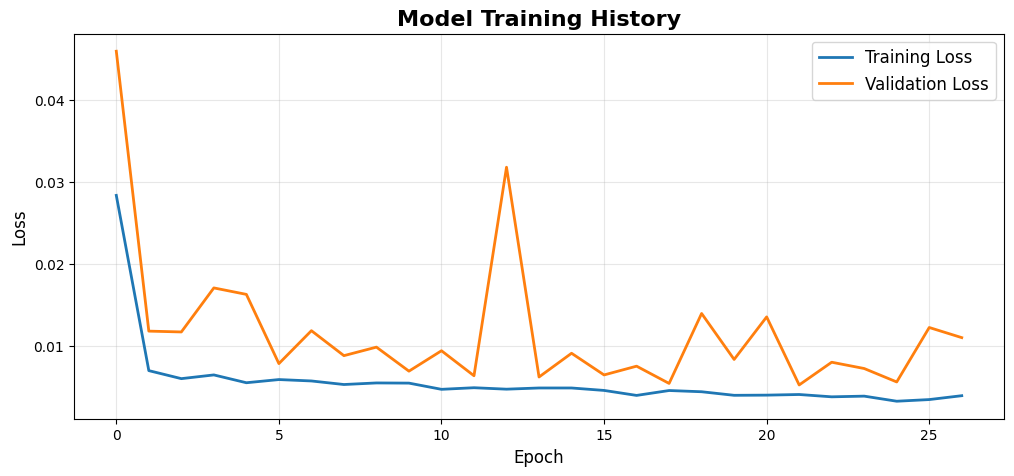

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training History', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 🔟 株価予測の実行

訓練したモデルを使って株価を予測します。

In [13]:
print("【予測実行】\n")

# 予測実行
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 実際の株価
actual_prices = close_prices[train_size:]
dates = stock_data.index[train_size:]

print(f"✓ {len(predictions)}日分の株価を予測しました\n")

【予測実行】

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
✓ 245日分の株価を予測しました



## 1️⃣1️⃣ 予測精度の評価

予測の精度を計算します。

In [14]:
# 評価指標を計算
rmse = np.sqrt(np.mean((actual_prices - predictions) ** 2))
mae = np.mean(np.abs(actual_prices - predictions))

# MAPEの計算（ゼロ除算を防ぐ）
# 株価がゼロの場合はスキップして計算
epsilon = 1e-10  # 非常に小さな値を追加してゼロ除算を防ぐ
mape = np.mean(np.abs((actual_prices - predictions) / (actual_prices + epsilon))) * 100

print("【予測精度】")
print(f"  RMSE (二乗平均平方根誤差): {rmse:.2f} 円")
print(f"  MAE  (平均絶対誤差):        {mae:.2f} 円")
print(f"  MAPE (平均絶対誤差率):      {mape:.2f} %")
print("\n※ 数値が小さいほど精度が高いです")

【予測精度】
  RMSE (二乗平均平方根誤差): 79.10 円
  MAE  (平均絶対誤差):        59.10 円
  MAPE (平均絶対誤差率):      3.16 %

※ 数値が小さいほど精度が高いです


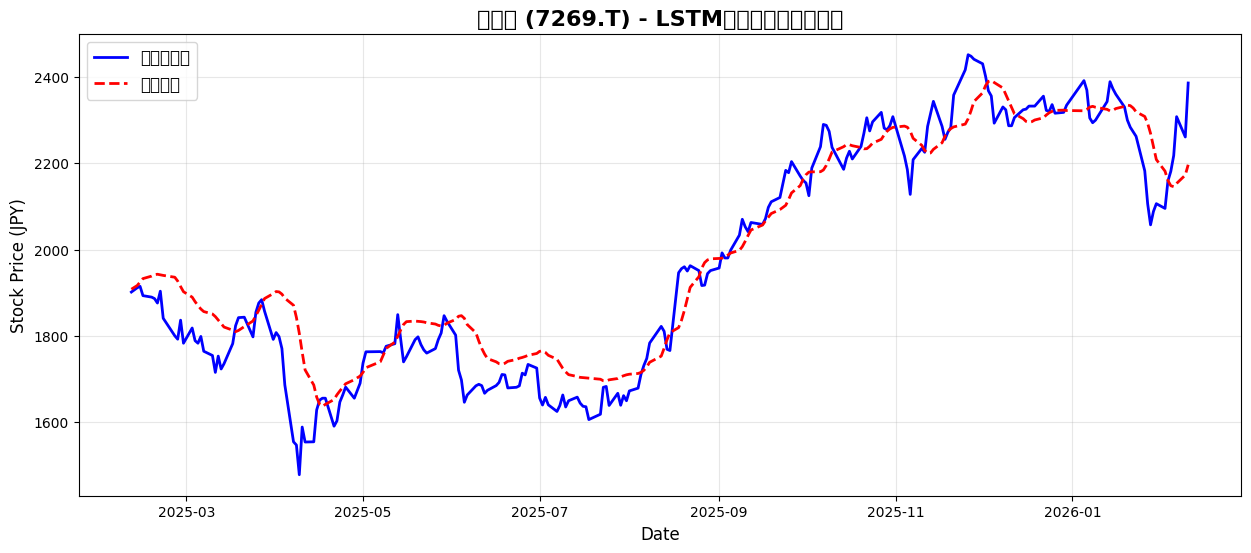

In [15]:
plt.figure(figsize=(15, 6))

# 実際の株価
plt.plot(dates, actual_prices, label='実際の株価', color='blue', linewidth=2)

# 予測された株価
plt.plot(dates, predictions, label='予測株価', color='red',
         linewidth=2, linestyle='--')

plt.title(f'{COMPANY_NAME} ({TICKER}) - LSTM株価予測（全期間）',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

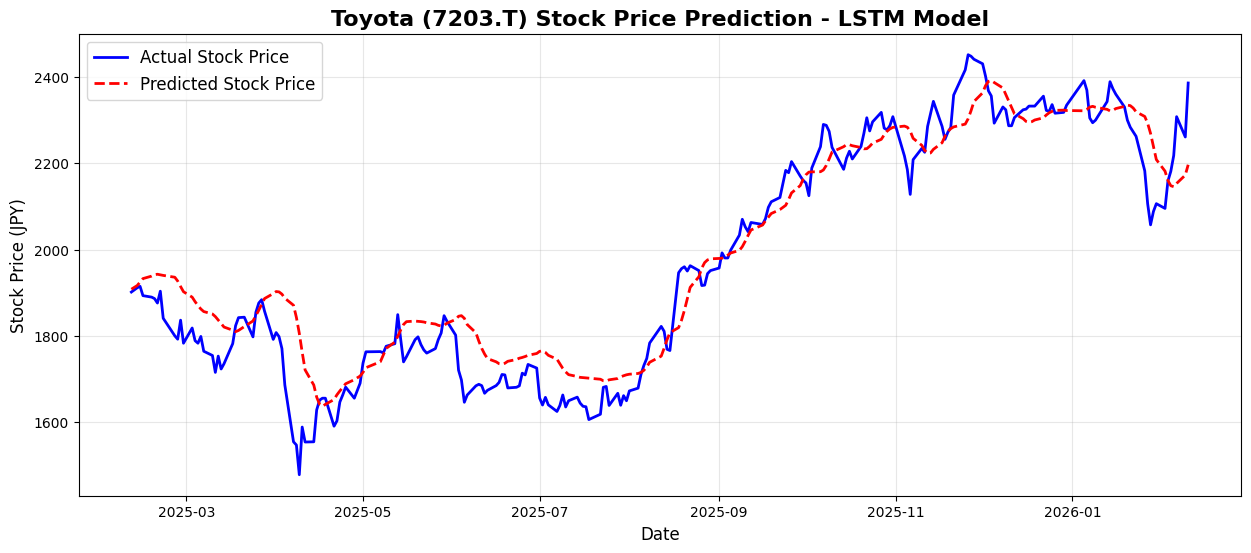

In [16]:
plt.figure(figsize=(15, 6))

# 実際の株価
plt.plot(dates, actual_prices, label='Actual Stock Price', color='blue', linewidth=2)

# 予測された株価
plt.plot(dates, predictions, label='Predicted Stock Price', color='red',
         linewidth=2, linestyle='--')

plt.title('Toyota (7203.T) Stock Price Prediction - LSTM Model',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

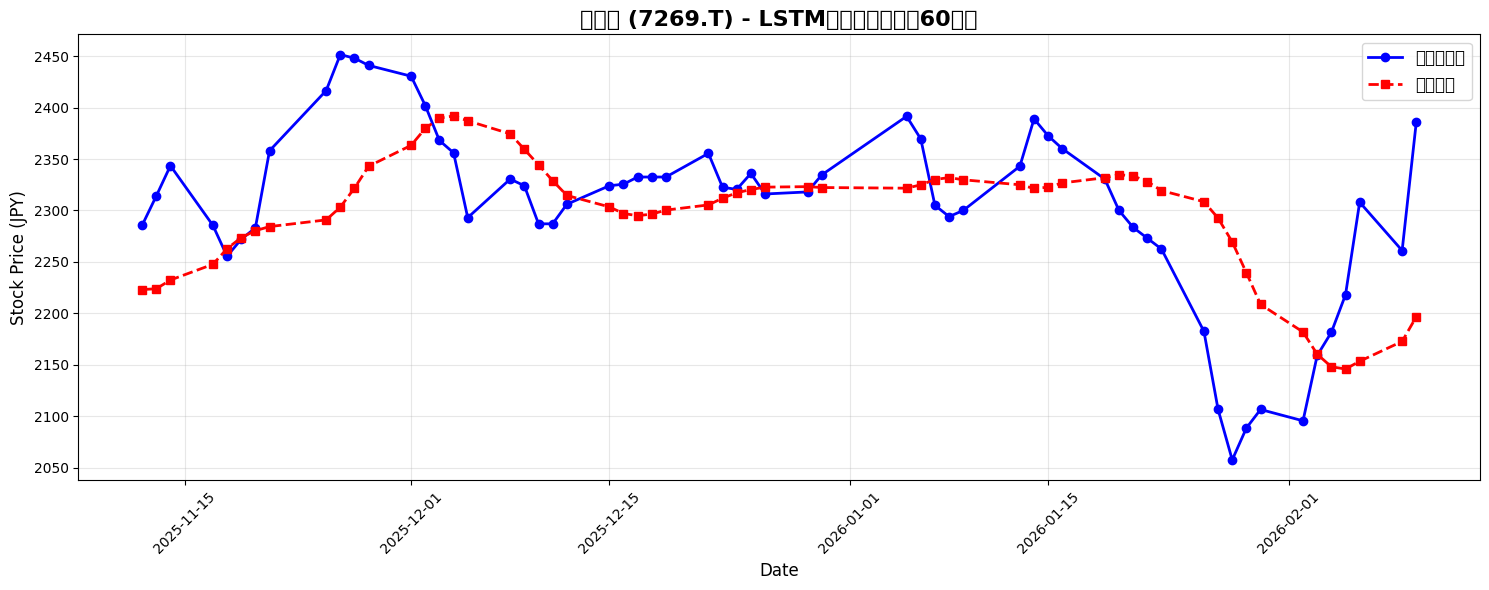

In [17]:
# 最近60日のデータのみ抽出
days = 60
recent_dates = dates[-days:]
recent_actual = actual_prices[-days:]
recent_predicted = predictions[-days:]

plt.figure(figsize=(15, 6))

# 実際の株価
plt.plot(recent_dates, recent_actual, label='実際の株価',
         color='blue', linewidth=2, marker='o')

# 予測された株価
plt.plot(recent_dates, recent_predicted, label='予測株価',
         color='red', linewidth=2, marker='s', linestyle='--')

plt.title(f'{COMPANY_NAME} ({TICKER}) - LSTM株価予測（直近{days}日）',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1️⃣4️⃣ 将来予測（x日先の株価予測）

訓練したモデルを使って、将来の株価を予測します。
パラメータ設定セルの`FORECAST_DAYS`で予測日数を変更できます。

In [18]:
print(f"【将来{FORECAST_DAYS}日間の株価予測】\n")

# 最新のデータからFORECAST_DAYS日先まで予測
last_sequence = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
future_predictions = []

# 反復予測：前の予測結果を使って次を予測
current_sequence = last_sequence.copy()

for i in range(FORECAST_DAYS):
    # 次の日を予測
    next_pred = model.predict(current_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])

    # シーケンスを更新（最古のデータを削除して、新しい予測を追加）
    current_sequence = np.append(current_sequence[:, 1:, :],
                                 next_pred.reshape(1, 1, 1),
                                 axis=1)

# 予測結果を元のスケールに戻す
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# 将来の日付を生成（営業日ベース）
last_date = stock_data.index[-1]
future_dates = pd.bdate_range(start=last_date + timedelta(days=1),
                               periods=FORECAST_DAYS)

print(f"✓ 将来{FORECAST_DAYS}日分の株価を予測しました\n")
print("【予測結果（最初の10日分）】")
for i in range(min(10, FORECAST_DAYS)):
    print(f"  {future_dates[i].date()}: {future_predictions[i][0]:.2f} 円")

if FORECAST_DAYS > 10:
    print(f"  ...")
    print(f"  {future_dates[-1].date()}: {future_predictions[-1][0]:.2f} 円")

【将来30日間の株価予測】

✓ 将来30日分の株価を予測しました

【予測結果（最初の10日分）】
  2026-02-11: 2228.18 円
  2026-02-12: 2253.33 円
  2026-02-13: 2270.85 円
  2026-02-16: 2281.95 円
  2026-02-17: 2288.48 円
  2026-02-18: 2292.03 円
  2026-02-19: 2293.76 円
  2026-02-20: 2294.40 円
  2026-02-23: 2294.38 円
  2026-02-24: 2293.95 円
  ...
  2026-03-24: 2282.05 円


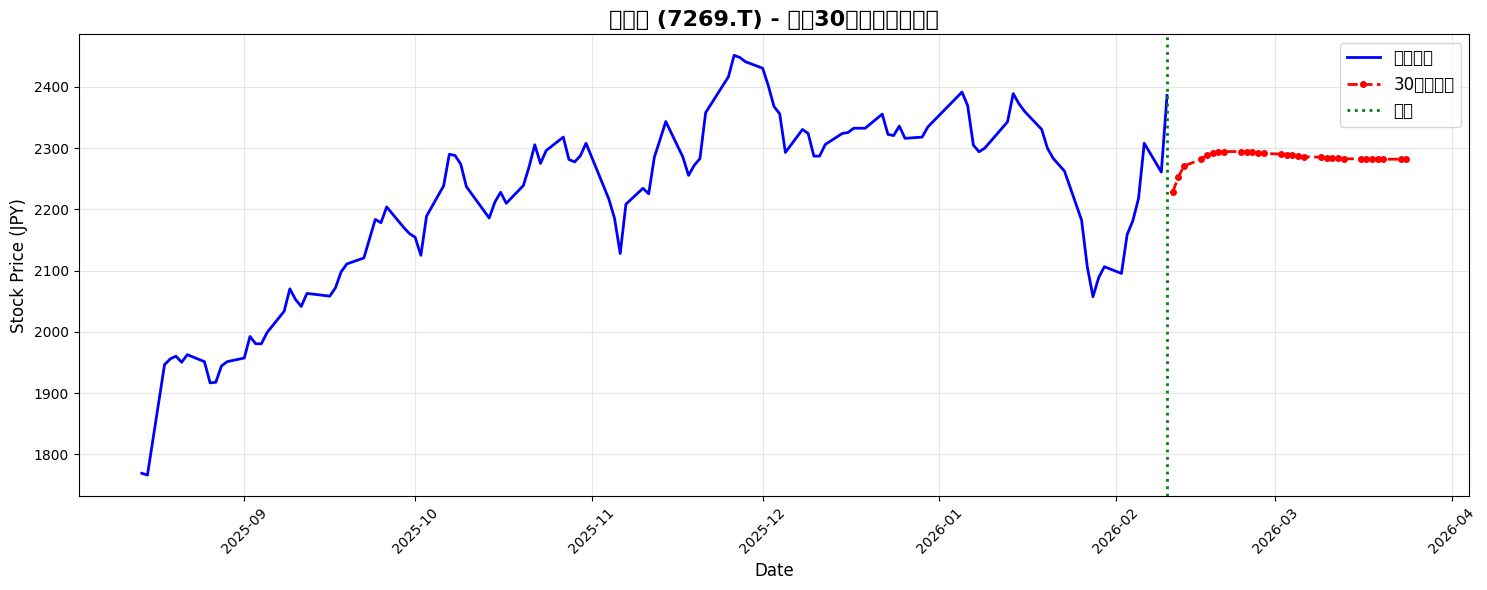


現在値: 2386.00 円
30日後予測値: 2282.05 円
予測変動率: -4.36%


In [19]:
# 将来予測のグラフ表示
plt.figure(figsize=(15, 6))

# 過去のデータ（最近120日分）
past_days = 120
past_dates = stock_data.index[-past_days:]
past_prices = close_prices[-past_days:]

# 過去の実績データをプロット
plt.plot(past_dates, past_prices, label='実績株価', color='blue', linewidth=2)

# 将来予測データをプロット
plt.plot(future_dates, future_predictions, label=f'{FORECAST_DAYS}日先予測',
         color='red', linewidth=2, linestyle='--', marker='o', markersize=4)

# 現在地点を強調
plt.axvline(x=stock_data.index[-1], color='green', linestyle=':',
            linewidth=2, label='現在')

plt.title(f'{COMPANY_NAME} ({TICKER}) - 将来{FORECAST_DAYS}日間の株価予測',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n現在値: {close_prices[-1][0]:.2f} 円")
print(f"{FORECAST_DAYS}日後予測値: {future_predictions[-1][0]:.2f} 円")
print(f"予測変動率: {((future_predictions[-1][0] - close_prices[-1][0]) / close_prices[-1][0] * 100):.2f}%")

## ✅ 完了！

すべての処理が完了しました。

### 📝 結果のまとめ

- データ取得: 完了
- モデル訓練: 完了
- 株価予測: 完了
- 将来予測: 完了
- 可視化: 完了

### 🔄 カスタマイズ方法

**1. 別の銘柄で試したい場合**

パラメータ設定セルの`TICKER`を変更してください：
```python
TICKER = "6758.T"  # ソニー
TICKER = "7974.T"  # 任天堂
TICKER = "9984.T"  # ソフトバンクグループ
```

または、銘柄検索機能を使って検索：
```python
search_stock('ソニー')  # 企業名から銘柄コードを検索
```

**2. 予測日数を変更する場合**

パラメータ設定セルの`FORECAST_DAYS`を変更してください：
```python
FORECAST_DAYS = 60  # 60日先まで予測
```

変更後、該当セルから順に再実行してください。

---

### 📚 参考情報

- 使用モデル: LSTM（Long Short-Term Memory）
- データ期間: 過去5年分
- 予測精度: MAPE（平均絶対誤差率）で評価

---

**⚠️ 免責事項**: このモデルは教育・学習目的です。実際の投資判断には使用しないでください。

## ✅ 完了！

すべての処理が完了しました。

### 📝 結果のまとめ

- データ取得: 完了
- モデル訓練: 完了
- 株価予測: 完了
- 可視化: 完了

### 🔄 カスタマイズ方法

**別の銘柄で試したい場合**は、セル3の`TICKER`を変更してください：
- ソニー: `TICKER = "6758.T"`
- 任天堂: `TICKER = "7974.T"`
- ソフトバンク: `TICKER = "9984.T"`

変更後、セル3から順に再実行してください。

---

**⚠️ 免責事項**: このモデルは教育・学習目的です。実際の投資判断には使用しないでください。